In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as torch_utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
manualSeed = 123
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


In [3]:
data_dir = "/kaggle/input/cartoon-faces-googles-cartoon-set"
model_save_path = "/kaggle/working/wgan.pt"
animation_save_path = "/kaggle/working/animations.mp4"
training_plot_save_path = "/kaggle/working/train_plot.jpeg"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
lr = 0.00005
beta1 = 0.5
batch_size = 64
noise_dim = 100
workers = 2
num_epochs = 25
# Number of discriminator updates for 1 generator update
n_critic = 5
# Clip value
clip = 0.01
# Monitor Progress
progress = list()
fixed_noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()

        conv_1 = self.conv_block(3, 64)
        conv_2 = self.conv_block(64, 128)
        conv_3 = self.conv_block(128, 256)
        conv_4 = self.conv_block(256, 512)

        self.classifier = nn.Sequential(
            conv_1,
            conv_2,
            conv_3,
            conv_4,
            nn.Conv2d(512, 1, (5, 5), 2, 1),
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (5, 5), 2, 2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.classifier(x)

In [6]:
# Generator
# This is same as DCGAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        upsample_1 = self.upsample_block(100, 1024, 0)
        upsample_2 = self.upsample_block(1024, 512, 1)
        upsample_3 = self.upsample_block(512, 256, 1)
        upsample_4 = self.upsample_block(256, 128, 1)

        self.gen = nn.Sequential(
            upsample_1,
            upsample_2,
            upsample_3,
            upsample_4,
            nn.ConvTranspose2d(128, 3, (4, 4), 2, 1),
            nn.Tanh(),
        )

    def upsample_block(self, in_channels, out_channels, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, (4, 4), 2, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.gen(x)

In [7]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
dataset = datasets.ImageFolder(root=data_dir,
                               transform=transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))

dataloader = data.DataLoader(dataset, 
                             batch_size=batch_size,
                             shuffle=True, 
                             num_workers=workers)

In [9]:
disc_net = Discriminator()
gen_net = Generator()
disc_net.to(device)
gen_net.to(device)
disc_net.apply(weights_init)
gen_net.apply(weights_init)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): ConvTranspose2d(128, 3, 

In [10]:
# Loss for discriminator
def disc_loss(real, fake):
    return torch.mean(fake) - torch.mean(real)

# Loss for generator
def gen_loss(fake):
    return -1.*torch.mean(fake)

disc_optimizer = optim.RMSprop(disc_net.parameters(), lr=lr)
gen_optimizer = optim.RMSprop(gen_net.parameters(), lr=lr)


In [11]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        real_images = data[0].to(device)
        num_images = real_images.size(0)  
        noise = torch.randn(num_images, noise_dim, 1, 1, device=device)

        # Training the discriminator (n_critic)
        # Train Discriminator on Real Images and Fake Images
        # Backpropagate the loss
        mean_disc_err = 0.
        for _ in range(n_critic):
            disc_net.zero_grad()

            real_output = disc_net(real_images).view(-1)

            fake = gen_net(noise)
            fake_output = disc_net(fake.detach()).view(-1)

            disc_err = disc_loss(real_output, fake_output)
            mean_disc_err += disc_err.item()
            disc_err.backward()
            disc_optimizer.step()

            # Clip weights of discriminator
            for p in disc_net.parameters():
                p.data.clamp_(-clip, clip)

        # Training the Generator - Every n_critic iterations
        # Steps:
        # 1. Get Discriminator Predictions on Fake Images
        # 2. Calculate loss
        gen_net.zero_grad()
        gen_images = gen_net(noise)

        output = disc_net(gen_images).view(-1)
        gen_err = gen_loss(output)

        gen_err.backward()
        gen_optimizer.step()

        # Training Update
        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {disc_err.item()}\tLoss_G: {gen_err.item()}"
            )

        # Tracking loss
        G_losses.append(gen_err.item())
        D_losses.append(mean_disc_err/n_critic)

        # Tracking Generator Progress
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = gen_net(fixed_noise).detach().cpu()
            progress.append(torch_utils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/25][0/1563]	Loss_D: -0.0857291966676712	Loss_G: 0.022355619817972183
[0/25][50/1563]	Loss_D: -1.2183151245117188	Loss_G: 0.601030707359314
[0/25][100/1563]	Loss_D: -1.3277533054351807	Loss_G: 0.6386995315551758
[0/25][150/1563]	Loss_D: -1.4293276071548462	Loss_G: 0.7112643718719482
[0/25][200/1563]	Loss_D: -1.3935853242874146	Loss_G: 0.7396624088287354
[0/25][250/1563]	Loss_D: -1.4897832870483398	Loss_G: 0.7495238184928894
[0/25][300/1563]	Loss_D: -0.8944443464279175	Loss_G: 0.734470784664154
[0/25][350/1563]	Loss_D: -1.5072710514068604	Loss_G: 0.7564292550086975
[0/25][400/1563]	Loss_D: -1.297830581665039	Loss_G: 0.73430335521698
[0/25][450/1563]	Loss_D: -1.4208927154541016	Loss_G: 0.7301490902900696
[0/25][500/1563]	Loss_D: -1.433571696281433	Loss_G: 0.7283525466918945
[0/25][550/1563]	Loss_D: -1.4296185970306396	Loss_G: 0.6928778290748596
[0/25][600/1563]	Loss_D: -1.4566707611083984	Loss_G: 0.7467164993286133
[0/25][650/1563]	Loss_D: -0.9558247327804565	

In [12]:
# Save generator
torch.save(gen_net, model_save_path)

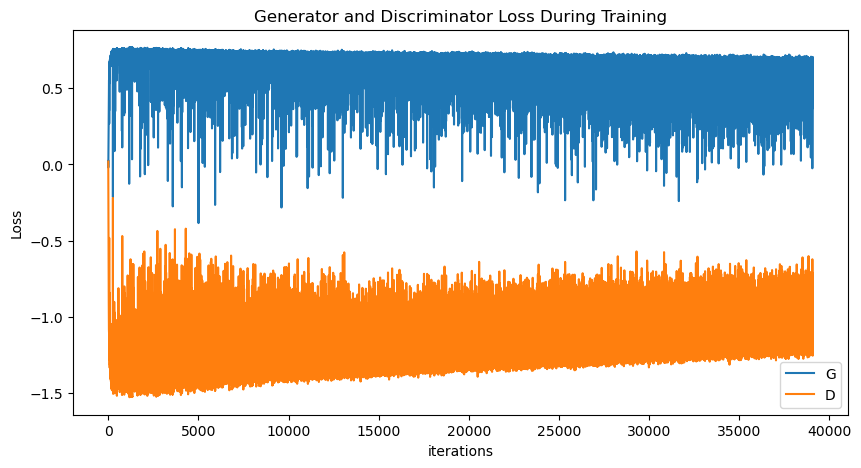

In [13]:
# Plot Training Graph
fig1 = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(training_plot_save_path)
plt.show()


In [14]:
# Progress Animation
fig2 = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in progress]
anim = animation.ArtistAnimation(fig2, ims, interval=1000, repeat_delay=1000, blit=True)
writervideo = animation.FFMpegWriter(fps=60)
anim.save(animation_save_path, writer=writervideo)
plt.close()
